# Classifying satelite images from Planet labs dataset using Retrained Resnet50

In this notebook we implement multilabel classification using a pretrained Resnet-50 on the dataset from [Planet Lab's understanding the Amazon from space competition.](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

This code is heavly inspired from [FastAI library](https://github.com/fastai/fastai) and was written for better understanding it.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from Planet.data import PlanetDataCollection
from Planet.scheduler import ParamScheduler
from Planet.utils import get_transforms, get_df
from Planet.train import NNTrainer 
from torchvision import models
from pathlib import Path

In [3]:
import torch
from torch import optim
from functools import partial

In [4]:
import math
from typing import Iterable
from torch import tensor
from torch import tensor

In [5]:
path = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/Planet')

In [6]:
tfms = get_transforms()

In [7]:
data = PlanetDataCollection.from_csv(path, 'train_v2.csv', 'train-jpg',
                           tfms, name_col='image_name', label_col='tags',
                           delimter=' ',bs=64,test_folder='test-jpg')

### Visualizing the Images
This is a sample of images taken from the training set.

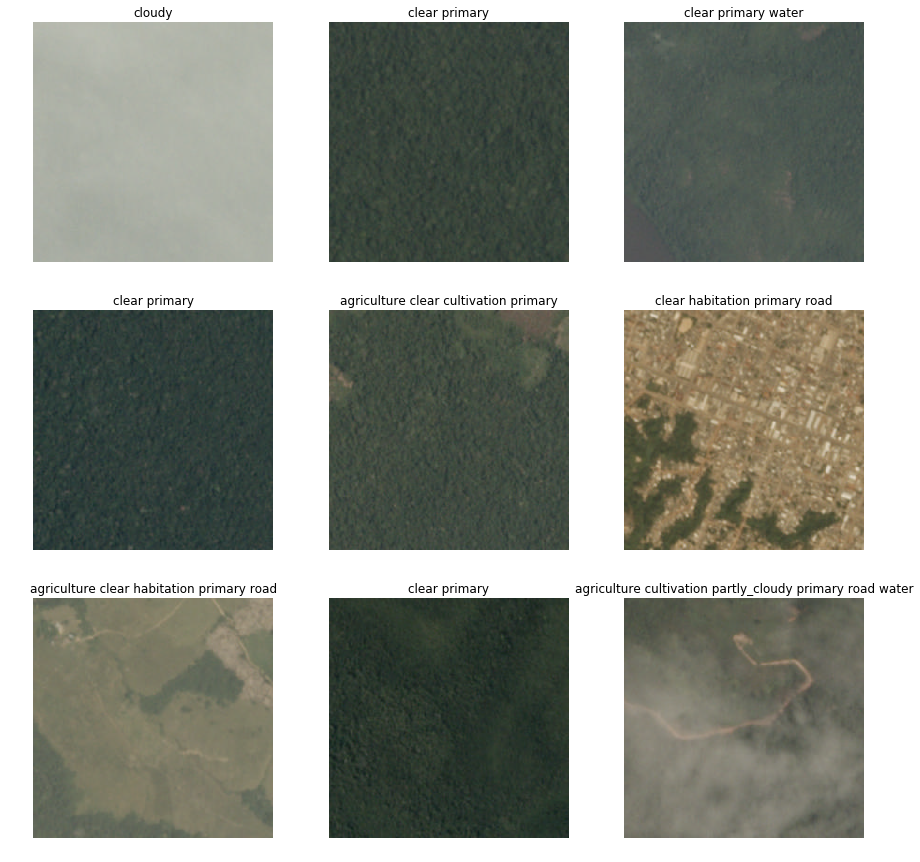

In [8]:
data.show()

In [9]:
arch = models.resnet50

In [10]:
def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [11]:
def annealer(f):
    def _inner(start, end): 
        return partial(f, start, end)
    return _inner

In [12]:
@annealer
def sched_lin(start, end, pos):
    return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start)/2
@annealer
def sched_no(start, end, pos):
    return start
@annealer
def sched_exp(start, end, pos):
    return start * (end/start) ** pos

In [13]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >=0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos - pcts[idx]) / (pcts[idx+1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [14]:
sched1 = combine_scheds([0.3, 0.7], [sched_cos(3e-4, 1e-2), sched_cos(1e-2, 1e-4)])
sched2 = combine_scheds([0.3, 0.7], [sched_cos(3e-5, 1e-3), sched_cos(1e-3, 1e-5)])

In [15]:
trainer = NNTrainer(data, arch, sched1, optim.Adam)

In [16]:
trainer.fit(2)

       Epoch            Training Loss       Validation Loss   
         0                 0.174577             0.135639      


         1                 0.143826             0.118769      


In [17]:
trainer.fit(2)

       Epoch            Training Loss       Validation Loss   
         0                 0.149726             0.131884      


         1                 0.141658             0.117936      


In [18]:
trainer.save('frozen1')

In [19]:
trainer.unfreeze()

In [22]:
from Planet.scheduler import ParamScheduler

In [23]:
trainer.sched = ParamScheduler('lr', sched2, trainer)

In [24]:
trainer.fit(4)

       Epoch            Training Loss       Validation Loss   
         0                 0.127422             0.120338      


         1                 0.113969             0.101351      


         2                 0.101546             0.089326      


         3                 0.090606             0.08405       


In [25]:
trainer.fit(2)

       Epoch            Training Loss       Validation Loss   
         0                 0.108424             0.099947      


         1                 0.098575             0.08554       


In [26]:
trainer.save('done')

In [27]:
trainer.load('done')

In [28]:
preds = trainer.predict_test()

In [29]:
df = get_df(preds,data)

In [30]:
data2 = PlanetDataCollection.from_csv(path, 'train_v2.csv', 'train-jpg',
                           tfms, name_col='image_name', label_col='tags',
                           delimter=' ',bs=64,test_folder='test-jpg-additional')

trainer.data = data2

In [31]:
preds2 = trainer.predict_test()

In [32]:
df2 = get_df(preds2, data2)

In [33]:
import pandas as pd
df3 = pd.concat([df, df2])

In [34]:
df3.to_csv('strange_submission.csv', index=False)

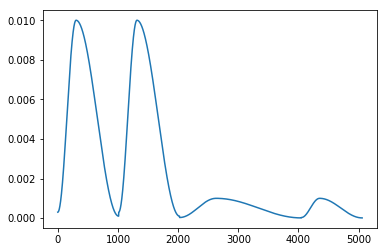

In [35]:
trainer.log.plot_lr()

In [ ]:
import torch